# Computing Mutual Information

In [2]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras.backend as K
from collections import defaultdict, OrderedDict
import seaborn as sns
sns.set_style('darkgrid')

# Saxe imports
import sys
sys.path.insert(0, '../estimators')
import utils
import kde
import simplebinmi

In [3]:
def load_obj(name):
    with open('../training_files/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Auxiliary functions for KDE estimator

In [4]:
# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 0.001                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

In [5]:
# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

In [6]:
DO_BINNED

False

In [7]:
DO_LOWER

False

## Training information

In [8]:
training_info = load_obj('tishby_epoch_8000_loss_019906')

## Input data

In [9]:
train, test = utils.get_IB_data('2017_12_21_16_51_3_275766')

In [10]:
train.X

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [11]:
train.Y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [12]:
train.y

array([1, 0, 1, ..., 0, 1, 0], dtype=uint8)

### Label dictionary `saved_labelixs` 

In [13]:
# Save indexes of tests data for each of the output classes
saved_labelixs = {}
FULL_MI = False
NUM_LABELS = 2

y = train.y
Y = train.Y

#y = test.y
#Y = test.Y

if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

## Computing MI

In [14]:
training_info.keys()

dict_keys(['epoch', 'loss', 'data', 'loss_gen'])

### Debugging

In [22]:
len(training_info['data'])

8000

In [23]:
len(training_info['data'][epoch]['activity'])

6

In [27]:
activity = training_info['data'][7999]['activity'][5]
activity

array([[0.00944319, 0.99055684],
       [0.5042464 , 0.49575353],
       [0.07286023, 0.92713976],
       ...,
       [0.98710144, 0.01289854],
       [0.0158016 , 0.9841984 ],
       [0.98747414, 0.01252583]], dtype=float32)

In [28]:
h_upper = entropy_func_upper([activity, ])[0]
h_upper

-1.9186409

In [29]:
hM_given_X = kde.kde_condentropy(activity, noise_variance)
hM_given_X

-4.0698782125727915

In [30]:
hM_given_Y_upper= 0.0
NUM_LABELS = 2
for i in range(NUM_LABELS):
    hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
    hM_given_Y_upper += labelprobs[i] * hcond_upper

In [31]:
hM_given_Y_upper

-2.431494355201721

In [32]:
h_upper - hM_given_Y_upper

0.5128535032272339

In [33]:
nats2bits*(h_upper - hM_given_Y_upper)

0.7398912058084623

### Measuring mutual information

In [20]:
#### This is an auxiliary dictionary to store the results for each epoch
# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}
#measures['relu'] = {}
PLOT_LAYERS    = None 
NUM_LABELS = 2


#### Main loop: over epochs

for epoch in range(0, len(training_info['data']), 10):
#for epoch in range(0, 1):
    
    cepochdata = defaultdict(list) 
    
    #training_info['data'][epoch]
    
    print('---- EPOCH %d' % epoch)
    
    
    #####################################################################
    num_layers = len(training_info['data'][epoch]['activity'])

    if PLOT_LAYERS is None:
        PLOT_LAYERS = []
        for lndx in range(num_layers):
            #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
            PLOT_LAYERS.append(lndx)
    #####################################################################
    
    for layer in range(len(training_info['data'][epoch]['activity'])):
        
        activity = training_info['data'][epoch]['activity'][layer] 
        
        #print(epoch)
        #print(layer)
        #print(activity)
        #break
        
        #### Compute marginal entropies
        h_upper = entropy_func_upper([activity, ])[0]
        if DO_LOWER: # Why computing lower bound would not be necessary?
            h_lower = entropy_func_lower([activity, ])[0]
            
        #### Layer activity given input. This is simply the entropy of the Gaussian noise
        hM_given_X = kde.kde_condentropy(activity, noise_variance)
        
        #### Compute conditional entropies of layer activity output
        hM_given_Y_upper= 0.0
        for i in range(NUM_LABELS):
            hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
            hM_given_Y_upper += labelprobs[i] * hcond_upper
            
        if DO_LOWER:
            hM_given_Y_lower=0.0
            for i in range(NUM_LABELS):
                hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_lower += labelprobs[i] * hcond_lower
                
        cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
        cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
        cepochdata['H_M_upper'  ].append( nats2bits * h_upper )
        pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], 
                                                        cepochdata['MI_YM_upper'][-1])
        
        #print(cepochdata)
        
        ### Compute lower bounds
        if DO_LOWER: 
            cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
            cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
            cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
            pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], 
                                                                cepochdata['MI_YM_lower'][-1])
        ### Compute binned estimates
        if DO_BINNED:
            binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
            cepochdata['MI_XM_bin'].append( nats2bits * binxm )
            cepochdata['MI_YM_bin'].append( nats2bits * binym )
            pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], 
                                                              cepochdata['MI_YM_bin'][-1])
            
        print('- Layer %d %s' % (layer, pstr) )
        
    measures['tanh'][epoch] = cepochdata
        

---- EPOCH 0
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.340, MI(Y;M)=0.901
- Layer 2 upper: MI(X;M)=6.962, MI(Y;M)=0.216
- Layer 3 upper: MI(X;M)=3.073, MI(Y;M)=0.072
- Layer 4 upper: MI(X;M)=1.274, MI(Y;M)=0.012
- Layer 5 upper: MI(X;M)=0.031, MI(Y;M)=0.000
---- EPOCH 10
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.340, MI(Y;M)=0.901
- Layer 2 upper: MI(X;M)=6.960, MI(Y;M)=0.215
- Layer 3 upper: MI(X;M)=3.075, MI(Y;M)=0.072
- Layer 4 upper: MI(X;M)=1.273, MI(Y;M)=0.012
- Layer 5 upper: MI(X;M)=0.032, MI(Y;M)=0.000
---- EPOCH 20
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.340, MI(Y;M)=0.901
- Layer 2 upper: MI(X;M)=6.959, MI(Y;M)=0.215
- Layer 3 upper: MI(X;M)=3.076, MI(Y;M)=0.072
- Layer 4 upper: MI(X;M)=1.272, MI(Y;M)=0.012
- Layer 5 upper: MI(X;M)=0.032, MI(Y;M)=0.000
---- EPOCH 30
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.340, MI(Y;M)=0.901
- Layer 2 upper: 

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.348, MI(Y;M)=0.903
- Layer 2 upper: MI(X;M)=6.956, MI(Y;M)=0.210
- Layer 3 upper: MI(X;M)=3.077, MI(Y;M)=0.070
- Layer 4 upper: MI(X;M)=1.248, MI(Y;M)=0.007
- Layer 5 upper: MI(X;M)=0.037, MI(Y;M)=0.000
---- EPOCH 290
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.348, MI(Y;M)=0.903
- Layer 2 upper: MI(X;M)=6.956, MI(Y;M)=0.210
- Layer 3 upper: MI(X;M)=3.076, MI(Y;M)=0.070
- Layer 4 upper: MI(X;M)=1.248, MI(Y;M)=0.007
- Layer 5 upper: MI(X;M)=0.037, MI(Y;M)=0.000
---- EPOCH 300
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.349, MI(Y;M)=0.903
- Layer 2 upper: MI(X;M)=6.957, MI(Y;M)=0.210
- Layer 3 upper: MI(X;M)=3.076, MI(Y;M)=0.070
- Layer 4 upper: MI(X;M)=1.247, MI(Y;M)=0.007
- Layer 5 upper: MI(X;M)=0.037, MI(Y;M)=0.000
---- EPOCH 310
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.349, MI(Y;M)=0.903
- Layer 2 upper: MI(X;M)=6.

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.360, MI(Y;M)=0.906
- Layer 2 upper: MI(X;M)=6.981, MI(Y;M)=0.205
- Layer 3 upper: MI(X;M)=3.067, MI(Y;M)=0.071
- Layer 4 upper: MI(X;M)=1.241, MI(Y;M)=0.004
- Layer 5 upper: MI(X;M)=0.037, MI(Y;M)=0.000
---- EPOCH 570
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.360, MI(Y;M)=0.906
- Layer 2 upper: MI(X;M)=6.982, MI(Y;M)=0.205
- Layer 3 upper: MI(X;M)=3.067, MI(Y;M)=0.071
- Layer 4 upper: MI(X;M)=1.242, MI(Y;M)=0.004
- Layer 5 upper: MI(X;M)=0.037, MI(Y;M)=0.000
---- EPOCH 580
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.361, MI(Y;M)=0.906
- Layer 2 upper: MI(X;M)=6.983, MI(Y;M)=0.205
- Layer 3 upper: MI(X;M)=3.066, MI(Y;M)=0.071
- Layer 4 upper: MI(X;M)=1.242, MI(Y;M)=0.004
- Layer 5 upper: MI(X;M)=0.037, MI(Y;M)=0.000
---- EPOCH 590
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.361, MI(Y;M)=0.906
- Layer 2 upper: MI(X;M)=6.

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.371, MI(Y;M)=0.909
- Layer 2 upper: MI(X;M)=7.015, MI(Y;M)=0.203
- Layer 3 upper: MI(X;M)=3.071, MI(Y;M)=0.075
- Layer 4 upper: MI(X;M)=1.257, MI(Y;M)=0.005
- Layer 5 upper: MI(X;M)=0.039, MI(Y;M)=0.000
---- EPOCH 850
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.371, MI(Y;M)=0.909
- Layer 2 upper: MI(X;M)=7.017, MI(Y;M)=0.203
- Layer 3 upper: MI(X;M)=3.071, MI(Y;M)=0.075
- Layer 4 upper: MI(X;M)=1.258, MI(Y;M)=0.005
- Layer 5 upper: MI(X;M)=0.039, MI(Y;M)=0.000
---- EPOCH 860
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.372, MI(Y;M)=0.909
- Layer 2 upper: MI(X;M)=7.018, MI(Y;M)=0.203
- Layer 3 upper: MI(X;M)=3.072, MI(Y;M)=0.075
- Layer 4 upper: MI(X;M)=1.259, MI(Y;M)=0.005
- Layer 5 upper: MI(X;M)=0.039, MI(Y;M)=0.000
---- EPOCH 870
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.372, MI(Y;M)=0.909
- Layer 2 upper: MI(X;M)=7.

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.380, MI(Y;M)=0.911
- Layer 2 upper: MI(X;M)=7.058, MI(Y;M)=0.204
- Layer 3 upper: MI(X;M)=3.091, MI(Y;M)=0.083
- Layer 4 upper: MI(X;M)=1.298, MI(Y;M)=0.011
- Layer 5 upper: MI(X;M)=0.046, MI(Y;M)=0.001
---- EPOCH 1130
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.381, MI(Y;M)=0.911
- Layer 2 upper: MI(X;M)=7.060, MI(Y;M)=0.204
- Layer 3 upper: MI(X;M)=3.092, MI(Y;M)=0.083
- Layer 4 upper: MI(X;M)=1.300, MI(Y;M)=0.011
- Layer 5 upper: MI(X;M)=0.046, MI(Y;M)=0.001
---- EPOCH 1140
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.381, MI(Y;M)=0.911
- Layer 2 upper: MI(X;M)=7.061, MI(Y;M)=0.205
- Layer 3 upper: MI(X;M)=3.093, MI(Y;M)=0.084
- Layer 4 upper: MI(X;M)=1.302, MI(Y;M)=0.011
- Layer 5 upper: MI(X;M)=0.046, MI(Y;M)=0.001
---- EPOCH 1150
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.381, MI(Y;M)=0.911
- Layer 2 upper: MI(X;M)

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.388, MI(Y;M)=0.912
- Layer 2 upper: MI(X;M)=7.109, MI(Y;M)=0.208
- Layer 3 upper: MI(X;M)=3.130, MI(Y;M)=0.095
- Layer 4 upper: MI(X;M)=1.368, MI(Y;M)=0.022
- Layer 5 upper: MI(X;M)=0.060, MI(Y;M)=0.002
---- EPOCH 1410
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.389, MI(Y;M)=0.912
- Layer 2 upper: MI(X;M)=7.111, MI(Y;M)=0.208
- Layer 3 upper: MI(X;M)=3.131, MI(Y;M)=0.095
- Layer 4 upper: MI(X;M)=1.371, MI(Y;M)=0.023
- Layer 5 upper: MI(X;M)=0.061, MI(Y;M)=0.003
---- EPOCH 1420
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.389, MI(Y;M)=0.912
- Layer 2 upper: MI(X;M)=7.113, MI(Y;M)=0.209
- Layer 3 upper: MI(X;M)=3.133, MI(Y;M)=0.096
- Layer 4 upper: MI(X;M)=1.375, MI(Y;M)=0.023
- Layer 5 upper: MI(X;M)=0.061, MI(Y;M)=0.003
---- EPOCH 1430
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.389, MI(Y;M)=0.912
- Layer 2 upper: MI(X;M)

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.395, MI(Y;M)=0.913
- Layer 2 upper: MI(X;M)=7.169, MI(Y;M)=0.215
- Layer 3 upper: MI(X;M)=3.188, MI(Y;M)=0.110
- Layer 4 upper: MI(X;M)=1.477, MI(Y;M)=0.040
- Layer 5 upper: MI(X;M)=0.087, MI(Y;M)=0.006
---- EPOCH 1690
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.396, MI(Y;M)=0.913
- Layer 2 upper: MI(X;M)=7.171, MI(Y;M)=0.215
- Layer 3 upper: MI(X;M)=3.191, MI(Y;M)=0.110
- Layer 4 upper: MI(X;M)=1.481, MI(Y;M)=0.041
- Layer 5 upper: MI(X;M)=0.088, MI(Y;M)=0.006
---- EPOCH 1700
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.396, MI(Y;M)=0.913
- Layer 2 upper: MI(X;M)=7.174, MI(Y;M)=0.216
- Layer 3 upper: MI(X;M)=3.193, MI(Y;M)=0.111
- Layer 4 upper: MI(X;M)=1.486, MI(Y;M)=0.042
- Layer 5 upper: MI(X;M)=0.090, MI(Y;M)=0.006
---- EPOCH 1710
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.396, MI(Y;M)=0.913
- Layer 2 upper: MI(X;M)

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.402, MI(Y;M)=0.914
- Layer 2 upper: MI(X;M)=7.242, MI(Y;M)=0.225
- Layer 3 upper: MI(X;M)=3.272, MI(Y;M)=0.129
- Layer 4 upper: MI(X;M)=1.636, MI(Y;M)=0.066
- Layer 5 upper: MI(X;M)=0.140, MI(Y;M)=0.014
---- EPOCH 1970
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.402, MI(Y;M)=0.914
- Layer 2 upper: MI(X;M)=7.245, MI(Y;M)=0.226
- Layer 3 upper: MI(X;M)=3.275, MI(Y;M)=0.130
- Layer 4 upper: MI(X;M)=1.642, MI(Y;M)=0.067
- Layer 5 upper: MI(X;M)=0.143, MI(Y;M)=0.014
---- EPOCH 1980
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.402, MI(Y;M)=0.914
- Layer 2 upper: MI(X;M)=7.248, MI(Y;M)=0.226
- Layer 3 upper: MI(X;M)=3.279, MI(Y;M)=0.130
- Layer 4 upper: MI(X;M)=1.649, MI(Y;M)=0.068
- Layer 5 upper: MI(X;M)=0.145, MI(Y;M)=0.015
---- EPOCH 1990
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.403, MI(Y;M)=0.914
- Layer 2 upper: MI(X;M)

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.407, MI(Y;M)=0.916
- Layer 2 upper: MI(X;M)=7.332, MI(Y;M)=0.240
- Layer 3 upper: MI(X;M)=3.389, MI(Y;M)=0.152
- Layer 4 upper: MI(X;M)=1.862, MI(Y;M)=0.101
- Layer 5 upper: MI(X;M)=0.247, MI(Y;M)=0.032
---- EPOCH 2250
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.407, MI(Y;M)=0.916
- Layer 2 upper: MI(X;M)=7.336, MI(Y;M)=0.240
- Layer 3 upper: MI(X;M)=3.394, MI(Y;M)=0.153
- Layer 4 upper: MI(X;M)=1.872, MI(Y;M)=0.102
- Layer 5 upper: MI(X;M)=0.253, MI(Y;M)=0.033
---- EPOCH 2260
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.407, MI(Y;M)=0.916
- Layer 2 upper: MI(X;M)=7.339, MI(Y;M)=0.241
- Layer 3 upper: MI(X;M)=3.399, MI(Y;M)=0.154
- Layer 4 upper: MI(X;M)=1.882, MI(Y;M)=0.103
- Layer 5 upper: MI(X;M)=0.259, MI(Y;M)=0.034
---- EPOCH 2270
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.407, MI(Y;M)=0.916
- Layer 2 upper: MI(X;M)

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.405, MI(Y;M)=0.916
- Layer 2 upper: MI(X;M)=7.445, MI(Y;M)=0.261
- Layer 3 upper: MI(X;M)=3.555, MI(Y;M)=0.181
- Layer 4 upper: MI(X;M)=2.180, MI(Y;M)=0.144
- Layer 5 upper: MI(X;M)=0.474, MI(Y;M)=0.074
---- EPOCH 2530
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.405, MI(Y;M)=0.916
- Layer 2 upper: MI(X;M)=7.450, MI(Y;M)=0.262
- Layer 3 upper: MI(X;M)=3.562, MI(Y;M)=0.182
- Layer 4 upper: MI(X;M)=2.194, MI(Y;M)=0.145
- Layer 5 upper: MI(X;M)=0.485, MI(Y;M)=0.076
---- EPOCH 2540
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.405, MI(Y;M)=0.915
- Layer 2 upper: MI(X;M)=7.455, MI(Y;M)=0.263
- Layer 3 upper: MI(X;M)=3.570, MI(Y;M)=0.183
- Layer 4 upper: MI(X;M)=2.207, MI(Y;M)=0.147
- Layer 5 upper: MI(X;M)=0.497, MI(Y;M)=0.078
---- EPOCH 2550
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.404, MI(Y;M)=0.915
- Layer 2 upper: MI(X;M)

- Layer 2 upper: MI(X;M)=7.600, MI(Y;M)=0.295
- Layer 3 upper: MI(X;M)=3.802, MI(Y;M)=0.218
- Layer 4 upper: MI(X;M)=2.626, MI(Y;M)=0.195
- Layer 5 upper: MI(X;M)=0.934, MI(Y;M)=0.149
---- EPOCH 2810
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.383, MI(Y;M)=0.905
- Layer 2 upper: MI(X;M)=7.606, MI(Y;M)=0.296
- Layer 3 upper: MI(X;M)=3.813, MI(Y;M)=0.220
- Layer 4 upper: MI(X;M)=2.645, MI(Y;M)=0.197
- Layer 5 upper: MI(X;M)=0.956, MI(Y;M)=0.153
---- EPOCH 2820
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.381, MI(Y;M)=0.904
- Layer 2 upper: MI(X;M)=7.613, MI(Y;M)=0.297
- Layer 3 upper: MI(X;M)=3.824, MI(Y;M)=0.221
- Layer 4 upper: MI(X;M)=2.664, MI(Y;M)=0.199
- Layer 5 upper: MI(X;M)=0.979, MI(Y;M)=0.156
---- EPOCH 2830
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.380, MI(Y;M)=0.904
- Layer 2 upper: MI(X;M)=7.619, MI(Y;M)=0.299
- Layer 3 upper: MI(X;M)=3.835, MI(Y;M)=0.223
- Layer 4 upper: MI(X;M)=2

- Layer 2 upper: MI(X;M)=7.823, MI(Y;M)=0.345
- Layer 3 upper: MI(X;M)=4.189, MI(Y;M)=0.270
- Layer 4 upper: MI(X;M)=3.259, MI(Y;M)=0.259
- Layer 5 upper: MI(X;M)=1.742, MI(Y;M)=0.244
---- EPOCH 3090
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.355, MI(Y;M)=0.888
- Layer 2 upper: MI(X;M)=7.833, MI(Y;M)=0.347
- Layer 3 upper: MI(X;M)=4.207, MI(Y;M)=0.273
- Layer 4 upper: MI(X;M)=3.286, MI(Y;M)=0.261
- Layer 5 upper: MI(X;M)=1.777, MI(Y;M)=0.248
---- EPOCH 3100
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.356, MI(Y;M)=0.888
- Layer 2 upper: MI(X;M)=7.843, MI(Y;M)=0.350
- Layer 3 upper: MI(X;M)=4.224, MI(Y;M)=0.275
- Layer 4 upper: MI(X;M)=3.313, MI(Y;M)=0.264
- Layer 5 upper: MI(X;M)=1.814, MI(Y;M)=0.251
---- EPOCH 3110
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.357, MI(Y;M)=0.888
- Layer 2 upper: MI(X;M)=7.853, MI(Y;M)=0.352
- Layer 3 upper: MI(X;M)=4.242, MI(Y;M)=0.278
- Layer 4 upper: MI(X;M)=3

- Layer 2 upper: MI(X;M)=8.202, MI(Y;M)=0.453
- Layer 3 upper: MI(X;M)=4.778, MI(Y;M)=0.370
- Layer 4 upper: MI(X;M)=4.112, MI(Y;M)=0.364
- Layer 5 upper: MI(X;M)=2.880, MI(Y;M)=0.359
---- EPOCH 3370
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.506, MI(Y;M)=0.952
- Layer 2 upper: MI(X;M)=8.218, MI(Y;M)=0.459
- Layer 3 upper: MI(X;M)=4.802, MI(Y;M)=0.375
- Layer 4 upper: MI(X;M)=4.145, MI(Y;M)=0.370
- Layer 5 upper: MI(X;M)=2.923, MI(Y;M)=0.365
---- EPOCH 3380
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.511, MI(Y;M)=0.955
- Layer 2 upper: MI(X;M)=8.233, MI(Y;M)=0.465
- Layer 3 upper: MI(X;M)=4.826, MI(Y;M)=0.381
- Layer 4 upper: MI(X;M)=4.178, MI(Y;M)=0.376
- Layer 5 upper: MI(X;M)=2.965, MI(Y;M)=0.371
---- EPOCH 3390
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.516, MI(Y;M)=0.957
- Layer 2 upper: MI(X;M)=8.248, MI(Y;M)=0.472
- Layer 3 upper: MI(X;M)=4.849, MI(Y;M)=0.387
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.605, MI(Y;M)=0.651
- Layer 3 upper: MI(X;M)=5.423, MI(Y;M)=0.575
- Layer 4 upper: MI(X;M)=4.916, MI(Y;M)=0.572
- Layer 5 upper: MI(X;M)=3.781, MI(Y;M)=0.568
---- EPOCH 3650
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.586, MI(Y;M)=0.983
- Layer 2 upper: MI(X;M)=8.626, MI(Y;M)=0.659
- Layer 3 upper: MI(X;M)=5.445, MI(Y;M)=0.582
- Layer 4 upper: MI(X;M)=4.936, MI(Y;M)=0.580
- Layer 5 upper: MI(X;M)=3.793, MI(Y;M)=0.576
---- EPOCH 3660
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.588, MI(Y;M)=0.985
- Layer 2 upper: MI(X;M)=8.645, MI(Y;M)=0.667
- Layer 3 upper: MI(X;M)=5.463, MI(Y;M)=0.588
- Layer 4 upper: MI(X;M)=4.953, MI(Y;M)=0.586
- Layer 5 upper: MI(X;M)=3.803, MI(Y;M)=0.582
---- EPOCH 3670
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.590, MI(Y;M)=0.986
- Layer 2 upper: MI(X;M)=8.659, MI(Y;M)=0.673
- Layer 3 upper: MI(X;M)=5.478, MI(Y;M)=0.594
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.033, MI(Y;M)=0.682
- Layer 3 upper: MI(X;M)=4.928, MI(Y;M)=0.636
- Layer 4 upper: MI(X;M)=4.439, MI(Y;M)=0.635
- Layer 5 upper: MI(X;M)=3.260, MI(Y;M)=0.630
---- EPOCH 3930
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.561, MI(Y;M)=0.984
- Layer 2 upper: MI(X;M)=8.021, MI(Y;M)=0.682
- Layer 3 upper: MI(X;M)=4.916, MI(Y;M)=0.636
- Layer 4 upper: MI(X;M)=4.427, MI(Y;M)=0.635
- Layer 5 upper: MI(X;M)=3.245, MI(Y;M)=0.630
---- EPOCH 3940
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.561, MI(Y;M)=0.984
- Layer 2 upper: MI(X;M)=8.011, MI(Y;M)=0.682
- Layer 3 upper: MI(X;M)=4.906, MI(Y;M)=0.636
- Layer 4 upper: MI(X;M)=4.416, MI(Y;M)=0.635
- Layer 5 upper: MI(X;M)=3.231, MI(Y;M)=0.630
---- EPOCH 3950
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.561, MI(Y;M)=0.984
- Layer 2 upper: MI(X;M)=8.003, MI(Y;M)=0.682
- Layer 3 upper: MI(X;M)=4.897, MI(Y;M)=0.636
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=7.958, MI(Y;M)=0.687
- Layer 3 upper: MI(X;M)=4.827, MI(Y;M)=0.642
- Layer 4 upper: MI(X;M)=4.309, MI(Y;M)=0.641
- Layer 5 upper: MI(X;M)=3.025, MI(Y;M)=0.634
---- EPOCH 4210
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.568, MI(Y;M)=0.985
- Layer 2 upper: MI(X;M)=7.959, MI(Y;M)=0.687
- Layer 3 upper: MI(X;M)=4.826, MI(Y;M)=0.643
- Layer 4 upper: MI(X;M)=4.307, MI(Y;M)=0.642
- Layer 5 upper: MI(X;M)=3.019, MI(Y;M)=0.634
---- EPOCH 4220
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.568, MI(Y;M)=0.985
- Layer 2 upper: MI(X;M)=7.960, MI(Y;M)=0.688
- Layer 3 upper: MI(X;M)=4.826, MI(Y;M)=0.643
- Layer 4 upper: MI(X;M)=4.306, MI(Y;M)=0.642
- Layer 5 upper: MI(X;M)=3.014, MI(Y;M)=0.634
---- EPOCH 4230
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.568, MI(Y;M)=0.986
- Layer 2 upper: MI(X;M)=7.960, MI(Y;M)=0.688
- Layer 3 upper: MI(X;M)=4.825, MI(Y;M)=0.643
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=7.997, MI(Y;M)=0.696
- Layer 3 upper: MI(X;M)=4.833, MI(Y;M)=0.651
- Layer 4 upper: MI(X;M)=4.290, MI(Y;M)=0.649
- Layer 5 upper: MI(X;M)=2.909, MI(Y;M)=0.638
---- EPOCH 4490
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.578, MI(Y;M)=0.986
- Layer 2 upper: MI(X;M)=7.999, MI(Y;M)=0.696
- Layer 3 upper: MI(X;M)=4.833, MI(Y;M)=0.651
- Layer 4 upper: MI(X;M)=4.290, MI(Y;M)=0.650
- Layer 5 upper: MI(X;M)=2.906, MI(Y;M)=0.638
---- EPOCH 4500
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.578, MI(Y;M)=0.986
- Layer 2 upper: MI(X;M)=8.002, MI(Y;M)=0.697
- Layer 3 upper: MI(X;M)=4.834, MI(Y;M)=0.651
- Layer 4 upper: MI(X;M)=4.290, MI(Y;M)=0.650
- Layer 5 upper: MI(X;M)=2.904, MI(Y;M)=0.638
---- EPOCH 4510
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.579, MI(Y;M)=0.986
- Layer 2 upper: MI(X;M)=8.004, MI(Y;M)=0.697
- Layer 3 upper: MI(X;M)=4.835, MI(Y;M)=0.652
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.072, MI(Y;M)=0.706
- Layer 3 upper: MI(X;M)=4.873, MI(Y;M)=0.659
- Layer 4 upper: MI(X;M)=4.311, MI(Y;M)=0.658
- Layer 5 upper: MI(X;M)=2.855, MI(Y;M)=0.643
---- EPOCH 4770
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.590, MI(Y;M)=0.987
- Layer 2 upper: MI(X;M)=8.075, MI(Y;M)=0.707
- Layer 3 upper: MI(X;M)=4.875, MI(Y;M)=0.659
- Layer 4 upper: MI(X;M)=4.312, MI(Y;M)=0.658
- Layer 5 upper: MI(X;M)=2.854, MI(Y;M)=0.643
---- EPOCH 4780
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.591, MI(Y;M)=0.987
- Layer 2 upper: MI(X;M)=8.079, MI(Y;M)=0.707
- Layer 3 upper: MI(X;M)=4.877, MI(Y;M)=0.660
- Layer 4 upper: MI(X;M)=4.314, MI(Y;M)=0.658
- Layer 5 upper: MI(X;M)=2.852, MI(Y;M)=0.643
---- EPOCH 4790
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.591, MI(Y;M)=0.987
- Layer 2 upper: MI(X;M)=8.082, MI(Y;M)=0.708
- Layer 3 upper: MI(X;M)=4.879, MI(Y;M)=0.660
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.174, MI(Y;M)=0.718
- Layer 3 upper: MI(X;M)=4.941, MI(Y;M)=0.667
- Layer 4 upper: MI(X;M)=4.360, MI(Y;M)=0.665
- Layer 5 upper: MI(X;M)=2.841, MI(Y;M)=0.648
---- EPOCH 5050
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.600, MI(Y;M)=0.988
- Layer 2 upper: MI(X;M)=8.178, MI(Y;M)=0.718
- Layer 3 upper: MI(X;M)=4.944, MI(Y;M)=0.667
- Layer 4 upper: MI(X;M)=4.362, MI(Y;M)=0.666
- Layer 5 upper: MI(X;M)=2.841, MI(Y;M)=0.648
---- EPOCH 5060
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.600, MI(Y;M)=0.988
- Layer 2 upper: MI(X;M)=8.182, MI(Y;M)=0.719
- Layer 3 upper: MI(X;M)=4.947, MI(Y;M)=0.667
- Layer 4 upper: MI(X;M)=4.365, MI(Y;M)=0.666
- Layer 5 upper: MI(X;M)=2.841, MI(Y;M)=0.649
---- EPOCH 5070
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.600, MI(Y;M)=0.988
- Layer 2 upper: MI(X;M)=8.186, MI(Y;M)=0.719
- Layer 3 upper: MI(X;M)=4.950, MI(Y;M)=0.668
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.296, MI(Y;M)=0.730
- Layer 3 upper: MI(X;M)=5.032, MI(Y;M)=0.674
- Layer 4 upper: MI(X;M)=4.430, MI(Y;M)=0.673
- Layer 5 upper: MI(X;M)=2.853, MI(Y;M)=0.654
---- EPOCH 5330
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.608, MI(Y;M)=0.988
- Layer 2 upper: MI(X;M)=8.301, MI(Y;M)=0.730
- Layer 3 upper: MI(X;M)=5.036, MI(Y;M)=0.674
- Layer 4 upper: MI(X;M)=4.433, MI(Y;M)=0.673
- Layer 5 upper: MI(X;M)=2.854, MI(Y;M)=0.655
---- EPOCH 5340
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.608, MI(Y;M)=0.989
- Layer 2 upper: MI(X;M)=8.306, MI(Y;M)=0.731
- Layer 3 upper: MI(X;M)=5.039, MI(Y;M)=0.675
- Layer 4 upper: MI(X;M)=4.436, MI(Y;M)=0.673
- Layer 5 upper: MI(X;M)=2.854, MI(Y;M)=0.655
---- EPOCH 5350
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.608, MI(Y;M)=0.989
- Layer 2 upper: MI(X;M)=8.310, MI(Y;M)=0.731
- Layer 3 upper: MI(X;M)=5.043, MI(Y;M)=0.675
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.433, MI(Y;M)=0.742
- Layer 3 upper: MI(X;M)=5.140, MI(Y;M)=0.682
- Layer 4 upper: MI(X;M)=4.514, MI(Y;M)=0.681
- Layer 5 upper: MI(X;M)=2.880, MI(Y;M)=0.662
---- EPOCH 5610
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.616, MI(Y;M)=0.990
- Layer 2 upper: MI(X;M)=8.439, MI(Y;M)=0.742
- Layer 3 upper: MI(X;M)=5.144, MI(Y;M)=0.682
- Layer 4 upper: MI(X;M)=4.518, MI(Y;M)=0.681
- Layer 5 upper: MI(X;M)=2.881, MI(Y;M)=0.662
---- EPOCH 5620
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.616, MI(Y;M)=0.990
- Layer 2 upper: MI(X;M)=8.444, MI(Y;M)=0.743
- Layer 3 upper: MI(X;M)=5.148, MI(Y;M)=0.682
- Layer 4 upper: MI(X;M)=4.521, MI(Y;M)=0.681
- Layer 5 upper: MI(X;M)=2.882, MI(Y;M)=0.663
---- EPOCH 5630
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.616, MI(Y;M)=0.990
- Layer 2 upper: MI(X;M)=8.449, MI(Y;M)=0.743
- Layer 3 upper: MI(X;M)=5.152, MI(Y;M)=0.683
- Layer 4 upper: MI(X;M)=4

- Layer 2 upper: MI(X;M)=8.582, MI(Y;M)=0.754
- Layer 3 upper: MI(X;M)=5.260, MI(Y;M)=0.690
- Layer 4 upper: MI(X;M)=4.607, MI(Y;M)=0.690
- Layer 5 upper: MI(X;M)=2.917, MI(Y;M)=0.671
---- EPOCH 5890
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.623, MI(Y;M)=0.992
- Layer 2 upper: MI(X;M)=8.587, MI(Y;M)=0.754
- Layer 3 upper: MI(X;M)=5.264, MI(Y;M)=0.690
- Layer 4 upper: MI(X;M)=4.610, MI(Y;M)=0.690
- Layer 5 upper: MI(X;M)=2.918, MI(Y;M)=0.672
---- EPOCH 5900
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.623, MI(Y;M)=0.992
- Layer 2 upper: MI(X;M)=8.593, MI(Y;M)=0.755
- Layer 3 upper: MI(X;M)=5.268, MI(Y;M)=0.691
- Layer 4 upper: MI(X;M)=4.614, MI(Y;M)=0.691
- Layer 5 upper: MI(X;M)=2.920, MI(Y;M)=0.672
---- EPOCH 5910
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.623, MI(Y;M)=0.992
- Layer 2 upper: MI(X;M)=8.598, MI(Y;M)=0.755
- Layer 3 upper: MI(X;M)=5.273, MI(Y;M)=0.691
- Layer 4 upper: MI(X;M)=4

- Layer 4 upper: MI(X;M)=4.703, MI(Y;M)=0.698
- Layer 5 upper: MI(X;M)=2.959, MI(Y;M)=0.680
---- EPOCH 6170
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.629, MI(Y;M)=0.993
- Layer 2 upper: MI(X;M)=8.743, MI(Y;M)=0.767
- Layer 3 upper: MI(X;M)=5.390, MI(Y;M)=0.699
- Layer 4 upper: MI(X;M)=4.707, MI(Y;M)=0.698
- Layer 5 upper: MI(X;M)=2.960, MI(Y;M)=0.681
---- EPOCH 6180
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.630, MI(Y;M)=0.993
- Layer 2 upper: MI(X;M)=8.749, MI(Y;M)=0.768
- Layer 3 upper: MI(X;M)=5.394, MI(Y;M)=0.699
- Layer 4 upper: MI(X;M)=4.710, MI(Y;M)=0.699
- Layer 5 upper: MI(X;M)=2.962, MI(Y;M)=0.681
---- EPOCH 6190
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.630, MI(Y;M)=0.993
- Layer 2 upper: MI(X;M)=8.755, MI(Y;M)=0.768
- Layer 3 upper: MI(X;M)=5.399, MI(Y;M)=0.699
- Layer 4 upper: MI(X;M)=4.713, MI(Y;M)=0.699
- Layer 5 upper: MI(X;M)=2.963, MI(Y;M)=0.681
---- EPOCH 6200
- Layer 0 

- Layer 4 upper: MI(X;M)=4.797, MI(Y;M)=0.705
- Layer 5 upper: MI(X;M)=3.001, MI(Y;M)=0.689
---- EPOCH 6450
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.637, MI(Y;M)=0.995
- Layer 2 upper: MI(X;M)=8.903, MI(Y;M)=0.781
- Layer 3 upper: MI(X;M)=5.516, MI(Y;M)=0.707
- Layer 4 upper: MI(X;M)=4.801, MI(Y;M)=0.705
- Layer 5 upper: MI(X;M)=3.002, MI(Y;M)=0.689
---- EPOCH 6460
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.637, MI(Y;M)=0.995
- Layer 2 upper: MI(X;M)=8.909, MI(Y;M)=0.782
- Layer 3 upper: MI(X;M)=5.520, MI(Y;M)=0.707
- Layer 4 upper: MI(X;M)=4.804, MI(Y;M)=0.705
- Layer 5 upper: MI(X;M)=3.003, MI(Y;M)=0.689
---- EPOCH 6470
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.637, MI(Y;M)=0.995
- Layer 2 upper: MI(X;M)=8.915, MI(Y;M)=0.782
- Layer 3 upper: MI(X;M)=5.525, MI(Y;M)=0.708
- Layer 4 upper: MI(X;M)=4.807, MI(Y;M)=0.705
- Layer 5 upper: MI(X;M)=3.005, MI(Y;M)=0.689
---- EPOCH 6480
- Layer 0 

- Layer 4 upper: MI(X;M)=4.886, MI(Y;M)=0.713
- Layer 5 upper: MI(X;M)=3.038, MI(Y;M)=0.698
---- EPOCH 6730
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.644, MI(Y;M)=0.996
- Layer 2 upper: MI(X;M)=9.063, MI(Y;M)=0.795
- Layer 3 upper: MI(X;M)=5.640, MI(Y;M)=0.716
- Layer 4 upper: MI(X;M)=4.889, MI(Y;M)=0.713
- Layer 5 upper: MI(X;M)=3.039, MI(Y;M)=0.698
---- EPOCH 6740
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.644, MI(Y;M)=0.996
- Layer 2 upper: MI(X;M)=9.069, MI(Y;M)=0.795
- Layer 3 upper: MI(X;M)=5.644, MI(Y;M)=0.716
- Layer 4 upper: MI(X;M)=4.892, MI(Y;M)=0.713
- Layer 5 upper: MI(X;M)=3.040, MI(Y;M)=0.698
---- EPOCH 6750
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.645, MI(Y;M)=0.996
- Layer 2 upper: MI(X;M)=9.074, MI(Y;M)=0.796
- Layer 3 upper: MI(X;M)=5.649, MI(Y;M)=0.716
- Layer 4 upper: MI(X;M)=4.895, MI(Y;M)=0.713
- Layer 5 upper: MI(X;M)=3.041, MI(Y;M)=0.699
---- EPOCH 6760
- Layer 0 

- Layer 4 upper: MI(X;M)=4.970, MI(Y;M)=0.721
- Layer 5 upper: MI(X;M)=3.069, MI(Y;M)=0.708
---- EPOCH 7010
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.650, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=9.218, MI(Y;M)=0.807
- Layer 3 upper: MI(X;M)=5.762, MI(Y;M)=0.724
- Layer 4 upper: MI(X;M)=4.973, MI(Y;M)=0.721
- Layer 5 upper: MI(X;M)=3.070, MI(Y;M)=0.708
---- EPOCH 7020
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.650, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=9.223, MI(Y;M)=0.808
- Layer 3 upper: MI(X;M)=5.767, MI(Y;M)=0.725
- Layer 4 upper: MI(X;M)=4.976, MI(Y;M)=0.722
- Layer 5 upper: MI(X;M)=3.071, MI(Y;M)=0.709
---- EPOCH 7030
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.651, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=9.229, MI(Y;M)=0.808
- Layer 3 upper: MI(X;M)=5.771, MI(Y;M)=0.725
- Layer 4 upper: MI(X;M)=4.979, MI(Y;M)=0.722
- Layer 5 upper: MI(X;M)=3.072, MI(Y;M)=0.709
---- EPOCH 7040
- Layer 0 

- Layer 4 upper: MI(X;M)=5.049, MI(Y;M)=0.729
- Layer 5 upper: MI(X;M)=3.092, MI(Y;M)=0.717
---- EPOCH 7290
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.655, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.365, MI(Y;M)=0.819
- Layer 3 upper: MI(X;M)=5.881, MI(Y;M)=0.732
- Layer 4 upper: MI(X;M)=5.051, MI(Y;M)=0.729
- Layer 5 upper: MI(X;M)=3.092, MI(Y;M)=0.717
---- EPOCH 7300
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.655, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.370, MI(Y;M)=0.820
- Layer 3 upper: MI(X;M)=5.886, MI(Y;M)=0.732
- Layer 4 upper: MI(X;M)=5.054, MI(Y;M)=0.729
- Layer 5 upper: MI(X;M)=3.093, MI(Y;M)=0.718
---- EPOCH 7310
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.656, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.375, MI(Y;M)=0.820
- Layer 3 upper: MI(X;M)=5.890, MI(Y;M)=0.733
- Layer 4 upper: MI(X;M)=5.057, MI(Y;M)=0.729
- Layer 5 upper: MI(X;M)=3.094, MI(Y;M)=0.718
---- EPOCH 7320
- Layer 0 

- Layer 4 upper: MI(X;M)=5.119, MI(Y;M)=0.738
- Layer 5 upper: MI(X;M)=3.106, MI(Y;M)=0.727
---- EPOCH 7570
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.659, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.501, MI(Y;M)=0.830
- Layer 3 upper: MI(X;M)=5.995, MI(Y;M)=0.741
- Layer 4 upper: MI(X;M)=5.121, MI(Y;M)=0.738
- Layer 5 upper: MI(X;M)=3.106, MI(Y;M)=0.727
---- EPOCH 7580
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.659, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.505, MI(Y;M)=0.830
- Layer 3 upper: MI(X;M)=5.999, MI(Y;M)=0.741
- Layer 4 upper: MI(X;M)=5.123, MI(Y;M)=0.738
- Layer 5 upper: MI(X;M)=3.106, MI(Y;M)=0.727
---- EPOCH 7590
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.659, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.510, MI(Y;M)=0.831
- Layer 3 upper: MI(X;M)=6.003, MI(Y;M)=0.741
- Layer 4 upper: MI(X;M)=5.126, MI(Y;M)=0.739
- Layer 5 upper: MI(X;M)=3.107, MI(Y;M)=0.728
---- EPOCH 7600
- Layer 0 

- Layer 4 upper: MI(X;M)=5.179, MI(Y;M)=0.745
- Layer 5 upper: MI(X;M)=3.108, MI(Y;M)=0.735
---- EPOCH 7850
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.660, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.623, MI(Y;M)=0.841
- Layer 3 upper: MI(X;M)=6.103, MI(Y;M)=0.750
- Layer 4 upper: MI(X;M)=5.181, MI(Y;M)=0.746
- Layer 5 upper: MI(X;M)=3.108, MI(Y;M)=0.736
---- EPOCH 7860
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.660, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.627, MI(Y;M)=0.841
- Layer 3 upper: MI(X;M)=6.107, MI(Y;M)=0.750
- Layer 4 upper: MI(X;M)=5.183, MI(Y;M)=0.746
- Layer 5 upper: MI(X;M)=3.108, MI(Y;M)=0.736
---- EPOCH 7870
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.660, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=9.631, MI(Y;M)=0.841
- Layer 3 upper: MI(X;M)=6.111, MI(Y;M)=0.750
- Layer 4 upper: MI(X;M)=5.185, MI(Y;M)=0.746
- Layer 5 upper: MI(X;M)=3.108, MI(Y;M)=0.736
---- EPOCH 7880
- Layer 0 

In [20]:
DO_SAVE = False

## Plot

/home/rodrigo/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


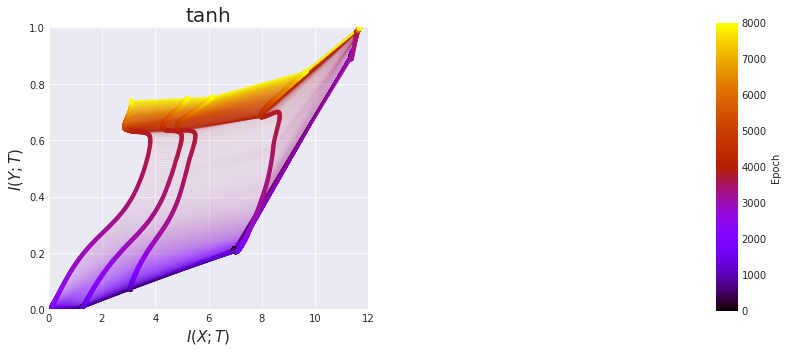

In [21]:
COLORBAR_MAX_EPOCHS= 8000
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    
    #print(vals)
    
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]
        
       
        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('$I(X;T)$', fontsize= 15)
    plt.ylabel('$I(Y;T)$', fontsize= 15)
    plt.title(activation, fontsize= 20)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    #plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')
    plt.savefig('plots/info_plane_no_mini_batch')